Importing Libraries

In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

Load Dataset

In [31]:
# Load dataset
df = pd.read_csv('/content/clvdata.csv', encoding='Latin1')

EDA

In [32]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [33]:
df.describe()

,Quantity,Price,Customer ID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [35]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [36]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

Preprocessing

In [38]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [39]:
# Remove missing Customer ID
df = df.dropna(subset=['Customer ID'])

In [40]:
# Remove missing Description
df = df.dropna(subset=['Description'])

In [43]:
df.shape

(406830, 8)

In [44]:
# Remove duplicates
df = df.drop_duplicates()

In [45]:
df.shape

(401605, 8)

In [46]:
# Remove entries with negative or zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [47]:
df.shape

(392693, 8)

In [48]:
# Calculate total sales per row
df['TotalSales'] = df['Quantity'] * df['Price']

In [49]:
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Generate new table

In [50]:
# Calculate Recency, Frequency, and Monetary values
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm_table = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSales': 'sum'
}).reset_index()

In [51]:
rfm_table.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalSales': 'Monetary'
}, inplace=True)

In [53]:
rfm_table

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40
...,...,...,...,...
4333,18280.0,278,1,180.60
4334,18281.0,181,1,80.82
4335,18282.0,8,2,178.05
4336,18283.0,4,16,2045.53


In [55]:
# Remove outliers for RFM
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [56]:
rfm_table = remove_outliers(rfm_table, 'Recency')
rfm_table = remove_outliers(rfm_table, 'Frequency')
rfm_table = remove_outliers(rfm_table, 'Monetary')

In [57]:
# Calculate CLV as the target variable
rfm_table['CLV'] = (rfm_table['Monetary'] * rfm_table['Frequency']) / rfm_table['Recency']

In [58]:
rfm_table

,Customer ID,Recency,Frequency,Monetary,CLV
2,12348.0,75,4,1797.24,95.852800
3,12349.0,19,1,1757.55,92.502632
4,12350.0,310,1,334.40,1.078710
5,12352.0,36,8,2506.04,556.897778
6,12353.0,204,1,89.00,0.436275
...,...,...,...,...,...
4332,18278.0,74,1,173.90,2.350000
4333,18280.0,278,1,180.60,0.649640
4334,18281.0,181,1,80.82,0.446519
4335,18282.0,8,2,178.05,44.512500


Model Training

In [59]:
# Features and target
features = rfm_table[['Recency', 'Frequency', 'Monetary']]
target = rfm_table['CLV']

In [60]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [61]:
# Initialize and train regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [62]:
# Predict CLV on test set
y_pred = model.predict(X_test)

In [65]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 26062.276632485413
R-squared: 0.9856052349515715


Checking Error

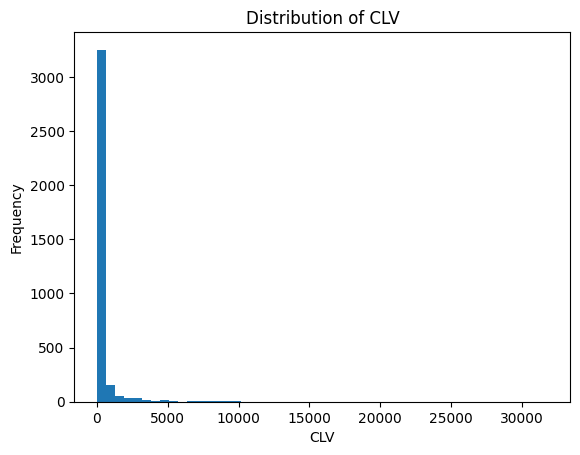

count     3604.000000
mean       346.156691
std       1429.910918
min          0.012584
25%          3.893899
50%         19.953379
75%        133.454154
max      31852.040000
Name: CLV, dtype: float64


In [66]:
import matplotlib.pyplot as plt

plt.hist(rfm_table['CLV'], bins=50)
plt.xlabel('CLV')
plt.ylabel('Frequency')
plt.title('Distribution of CLV')
plt.show()

print(rfm_table['CLV'].describe())


In [67]:
mean_clv = rfm_table['CLV'].mean()
print("Average CLV:", mean_clv)

Average CLV: 346.15669116682113


In [68]:
from math import sqrt

rmse = sqrt(mse)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 161.43815110588145


In [69]:
rmse_proportion = rmse / mean_clv
print("RMSE as a proportion of mean CLV:", rmse_proportion)


RMSE as a proportion of mean CLV: 0.46637304788680384


In [71]:
import joblib

# Save the trained model
joblib.dump(model, 'clv_model.pkl')

['clv_model.pkl']

Deploy

In [78]:
# Load the trained model
model = joblib.load('clv_model.pkl')

def get_user_input():
    recency = float(input("Enter Recency (days since last purchase): "))
    frequency = int(input("Enter Frequency (number of purchases): "))
    monetary = float(input("Enter Monetary (total spend): "))
    return [[recency, frequency, monetary]]

def predict_clv(model, user_input):
    prediction = model.predict(user_input)
    return prediction[0]

if __name__ == "__main__":
    user_input = get_user_input()
    clv_prediction = predict_clv(model, user_input)
    print(f"Predicted Customer Lifetime Value (CLV): {clv_prediction:.2f}")


Enter Recency (days since last purchase): 30
Enter Frequency (number of purchases): 27
Enter Monetary (total spend): 30090
Predicted Customer Lifetime Value (CLV): 965.56


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
